# Biological Signals Analysis - Week 10 Exercise
# Neural Decoding
### March 13, 2024

### Introduction to Neural Decoding

Decoding in neuroscience refers to the interpretation of neural signals to infer the original sensory stimulus or the intended motor action. This field holds significant importance in understanding brain function and developing brain-computer interfaces.
In this session, we'll explore the principles and applications of Linear Stimulus Reconstruction (LSR) in neural coding. LSR is a method used to predict the external stimulus that caused a neuron's spike activity. We will discuss its mathematical foundation, introduce the concepts of linear filtering, and the role of least-squares regression in decoding neural signals.

#### Part 1: Bayesian Framework for Neural Decoding

Bayes' theorem is a foundational principle in probability theory and statistics, and it is crucial for understanding the process of neural decoding. In the context of neuroscience, neural decoding involves interpreting the spikes or firing rates from neurons in response to stimuli. Let's break down Bayes' theorem and its key components, which we will use throughout our exploration of neural decoding:

- **$ r $**: Represents the firing rate or the response of our neural system.
- **$ s $**: Denotes the stimulus.
- **$ P(s) $**: The probability of a stimulus $ s $ being presented.
- **$ P(r) $**: The probability of receiving a response $ r $.
- **$ P(r, s) $**: The joint probability of both stimulus $ s $ and response $ r $ occurring.
- **$ P(r|s) $**: The probability of evoking response $ r $ given that stimulus $ s $ was presented (the encoding probability).
- **$ P(s|r) $**: The probability of stimulus $ s $ being presented given the response $ r $ (the decoding probability).

Bayes' theorem provides a way to update our probability estimates for a hypothesis as we gain more evidence. It is written as:

$ P(s|r) = \frac{P(r|s)P(s)}{P(r)} $

In words, Bayes' theorem states that the probability of the stimulus given the response is equal to the probability of the response given the stimulus times the probability of the stimulus, all divided by the probability of the response.

This theorem allows us to reverse the conditional probability, thereby moving from the probability of observing the data given a known hypothesis (the encoding model) to the probability of the hypothesis given the observed data (the decoding model).

In [1]:
import numpy as np

# Define probabilities
P_s = 0.2  # P(s) - the prior probability of the stimulus
P_r_given_s = 0.7  # P(r|s) - the probability of the response given the stimulus
P_r = 0.3  # P(r) - the probability of the response

# Apply Bayes' theorem to find P(s|r)
P_s_given_r = (P_r_given_s * P_s) / P_r

print(f"The probability of the stimulus given the response (P(s|r)) is: {P_s_given_r:.2f}")

The probability of the stimulus given the response (P(s|r)) is: 0.47


In the above example, we have chosen arbitrary values for $ P(s) $, $ P(r|s) $, and $ P(r) $. By plugging these into Bayes' theorem, we calculate the posterior probability $ P(s|r) $, which gives us an updated belief about the occurrence of the stimulus given the response we've observed. This process is at the heart of neural decoding, where we interpret neuronal firing rates to determine the most likely stimulus that caused them.

#### Part 1.1: Discrimination in Neural Decoding

Discrimination is a fundamental task of a decoding system, where the goal is to categorize the input, often a stimulus, into one of two discrete categories or values. In the context of neural decoding, this often comes down to deciding between two different stimuli based on the firing rates of neurons. This concept was elegantly demonstrated in a landmark study by Britten et al. in 1992, using a visual stimulus of moving dots with varying degrees of coherence to determine the firing rate response of neurons in the monkey's MT (middle temporal) area.

In the experiment, the monkeys were required to discriminate the direction of motion of the dots. When the coherence was high enough (over a certain threshold, such as 10%), the monkeys could discriminate the motion direction with high probability. This task is binary—there are only two choices—and the neuron's response can be thought of as a vote for one choice or the other.

The discrimination task can be understood in terms of signal detection theory, where we define:

- **$ d $**: The sensitivity index, a measure of how separated the neural response distributions are for the two choices. A higher $ d $ means the distributions are further apart, making it easier to discriminate.
- **$ z $**: The decision criterion, a threshold value of the firing rate. If the observed firing rate $ r $ is greater than $ z $, we categorize the stimulus as $ r+ $; otherwise, as $ r- $.

Given a particular criterion $ z $, we can define two key probabilities:
- **Hit Rate (Power, $ \beta(z) $)**: The probability that the response will be $ r+ $ (correctly identifying a stimulus as $ r+ $) when the stimulus is actually $ r+ $. Mathematically, it's $ P(r \geq z | +) $.
- **False Alarm Rate (Size, $ \alpha(z) $)**: The probability that the response will be $ r+ $ when the stimulus is actually $ r- $. This is denoted by $ P(r \geq z | -) $.

These probabilities are crucial for constructing Receiver Operating Characteristic (ROC) curves, which graphically represent the trade-off between hit rates and false alarms as the decision criterion $ z $ varies.

We will simulate the process of discrimination by generating two Gaussian-distributed firing rates, one for each stimulus direction, and calculating the hit rate and false alarm rate for a range of decision criteria.

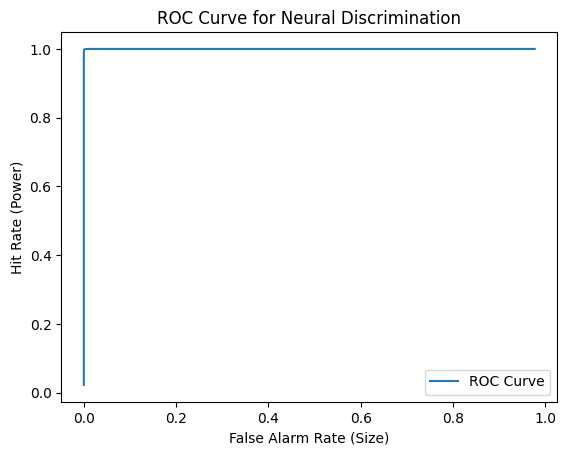

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define the distributions for two stimuli responses (r+ and r-)
r_plus_mean = 40  # Mean firing rate for r+
r_minus_mean = 10  # Mean firing rate for r-
common_std = 5  # Standard deviation for both distributions

# Define a range of decision criteria (z)
z_values = np.linspace(0, 50, 100)

# Calculate hit rate (power) and false alarm rate (size) for each z
hit_rates = [1 - norm.cdf(z, loc=r_plus_mean, scale=common_std) for z in z_values]
false_alarm_rates = [1 - norm.cdf(z, loc=r_minus_mean, scale=common_std) for z in z_values]

# Plot the ROC curve
plt.plot(false_alarm_rates, hit_rates, label='ROC Curve')
plt.xlabel('False Alarm Rate (Size)')
plt.ylabel('Hit Rate (Power)')
plt.title('ROC Curve for Neural Discrimination')
plt.legend()
plt.show()


This Python script uses the `norm.cdf` function from the `scipy.stats` module to compute the cumulative distribution function (CDF) for Gaussian distributions representing the neuron's firing rate response to two stimuli. By comparing these against a range of decision criteria (`z_values`), we can calculate the corresponding hit rates and false alarm rates to plot an ROC curve. This curve visualizes the trade-offs between correctly detecting stimuli (`r+`) and falsely detecting stimuli (`r-`) as the decision criterion varies.

#### Part 2: Receiver Operating Characteristic (ROC) Curves

ROC curves are graphical plots that illustrate the diagnostic ability of a binary classifier system as its discrimination threshold is varied. They are used to evaluate the trade-offs between true positive rates (sensitivity) and false positive rates (1-specificity) across different threshold settings.

In the context of neural decoding, each point on an ROC curve represents a different threshold value for the firing rate at which the neuron's response switches from one decision to another (e.g., from deciding the stimulus is moving left to deciding it is moving right).

The extremities of the ROC curve represent the following scenarios:
- When the threshold $ z = 0 $, all responses are considered a 'hit,' leading to a high rate of hits but also a high rate of false alarms. This corresponds to a point in the upper right corner of the ROC curve ($ \alpha = \beta = 1 $).
- Conversely, a very high threshold $ z $ will result in no responses being considered a 'hit,' reducing both hits and false alarms to zero, corresponding to the lower left corner of the ROC curve ($ \alpha = \beta = 0 $).

The ideal spot on the ROC curve is the top-left corner, signifying maximal sensitivity (hit rate) and minimal false alarm rate. The area under the ROC curve (AUC) is a measure of how well the classifier can distinguish between the two classes; an AUC of 0.5 corresponds to chance level, while an AUC of 1.0 corresponds to perfect classification.

For the Python demonstration, we will simulate the neuron's response to two stimuli and calculate the ROC curve, including the AUC.

In [ ]:
from sklearn.metrics import roc_curve, auc

# Assume we have collected neural responses to two stimuli (r+ and r-)
# These responses are represented as arrays where each entry is the firing rate for a particular trial
# For simplicity, we are generating random data
np.random.seed(0)
r_plus_responses = np.random.normal(loc=40, scale=5, size=1000)
r_minus_responses = np.random.normal(loc=20, scale=5, size=1000)

# Combine the responses and create labels (1 for r+ and 0 for r-)
responses = np.concatenate([r_plus_responses, r_minus_responses])
labels = np.concatenate([np.ones_like(r_plus_responses), np.zeros_like(r_minus_responses)])

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(labels, responses)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In the Python code, we've simulated neural responses to two stimulus types using a normal distribution for each stimulus type's response. We then calculate the true positive rate (TPR) and false positive rate (FPR) to plot the ROC curve. The `roc_curve` function from `sklearn.metrics` is used to calculate the TPR and FPR across various thresholds, and `auc` is used to calculate the area under the ROC curve. This plot gives us a visual representation of the classifier's performance across different thresholds.

#### Part 2.1: Two-alternative Forced Choice (2AFC) Test in Neural Decoding

The Two-alternative Forced Choice (2AFC) test is a method used to assess the discriminative ability of a subject when presented with two distinct stimuli. Instead of asking whether the stimulus is present or not, the 2AFC test asks which of two stimuli is being presented. This methodology effectively sets a relative threshold (the decision criterion z) based on the comparison between the two presented stimuli.

In the context of neural decoding, the 2AFC test could be used to determine how the brain discriminates between two different firing rates corresponding to different stimuli directions. The test forces the subject (or decoding system) to compare the current stimulus with a reference or previous stimulus, thereby setting a relative threshold for discrimination.

In [3]:
# Assuming r1 and r2 are the firing rates for two consecutive trials with different stimuli (+ and -)
# For the purpose of illustration, we'll generate these rates from normal distributions

# Define the mean firing rates for stimulus + and -
mean_r_plus = 50  # Firing rate for stimulus +
mean_r_minus = 30  # Firing rate for stimulus -

# Generate firing rates for two consecutive trials
np.random.seed(42)  # For reproducibility
r1 = np.random.normal(mean_r_plus, 10, 1000)  # Responses for stimulus +
r2 = np.random.normal(mean_r_minus, 10, 1000)  # Responses for stimulus -

# The probability of correctly identifying r1 as greater given it is from the + distribution
# For simplicity, we'll assume the decision threshold z is equal to r2
correct_identification = np.mean(r1 >= r2)

print(f"The probability of correctly identifying the stimulus as + given r1 >= z is: {correct_identification:.2f}")


The probability of correctly identifying the stimulus as + given r1 >= z is: 0.91


#### Part 2.2: Likelihood Ratio Test in Neural Decoding

The Likelihood Ratio Test (LRT) is another decision-making strategy used in neural decoding. Instead of directly comparing the firing rate to a threshold, LRT compares the ratio of the probabilities of the firing rate given two different stimuli. This is mathematically represented as:

$ l(r) = \frac{P(r|+)}{P(r|-)} $

This ratio compares the likelihood of observing the firing rate $ r $ under the hypothesis that the stimulus is $ + $ versus the hypothesis that the stimulus is $ - $. An optimal decision rule would be to choose the stimulus that maximizes this likelihood ratio.

For the Britten et al. experiment, this translates to a monotonically increasing function, meaning as the firing rate increases, the likelihood ratio also increases, allowing for a straightforward discrimination between the two hypotheses.


In [ ]:
# Define the likelihoods of r given + and r given - from the previous distributions
likelihood_r_given_plus = norm.pdf(r1, loc=mean_r_plus, scale=10)
likelihood_r_given_minus = norm.pdf(r1, loc=mean_r_minus, scale=10)

# Compute the likelihood ratio for each response r1
likelihood_ratios = likelihood_r_given_plus / likelihood_r_given_minus

# An optimal decision rule based on LRT would be to decide + if l(r) > 1, - otherwise
decisions = likelihood_ratios > 1
correct_decisions = decisions == (r1 > r2)  # Assuming r1 comes from + and r2 comes from -

# Calculate the percentage of correct decisions
percentage_correct = np.mean(correct_decisions)

print(f"The percentage of correct decisions using LRT is: {percentage_correct:.2f}")

In this Python example, we use the `norm.pdf` function to calculate the likelihood of observing each firing rate under both hypotheses. We then calculate the likelihood ratios and make decisions based on these ratios. The percentage of correct decisions gives an estimate of the discriminability of the two stimuli when using the Likelihood Ratio Test.